# pneumonia prediction
___

## Step 1. 실험환경 Set-up
---

In [2]:
#  프로젝트에서 사용할 패키지 목록
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 필요한 변수들을 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

데이터를 열어보면 이미 train, val(validation), test 로 나눠져 있다.

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있는 것을 확인헐 수 있음.

### 2-1. val 데이터 개수 추가

val 개수가 너무 없기 때문에 train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 다시 확인해보면 train은 4185개, test는 624개, val은 1047개가 된 것을 확인할 수 있음.

### 2-2. 정상 이미지 수와 폐렴 이미지 수

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 확인.

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


정상 이미지와 폐렴 이미지 수 세기

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다,

### 2-3. tf.data 인스턴스 만들기

tf.data 인스턴스를 만든다.
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 준다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인.

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 2-4. 라벨 데이터 만들기

현재 이미지에는 라벨 데이터가 따로 없다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 준다.

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2-5. decode_img 함수와 process_path 함수

 - 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높기 때문에 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다.

 - process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경. get_label을 이용해서 라벨 값 가져오기.

In [90]:
# 이미지를 알맞은 형식으로 바꿉니다.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

 - train 데이터 셋과 validation 데이터 셋을 만들어 준다.
 - num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하여 더욱 빠르게 데이터를 처리.

In [91]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

In [92]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미.

test 데이터셋도 만들어 주고 데이터 개수도 확인.

In [93]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.
  - 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 되는데 repeat()를 사용하면 자동으로 데이터를 맞춰준다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
  - 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

## Step 3. 데이터 시각화

- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출. 
- 추출된 배치를 image와 label 데이터 셋으로 나누고 show_batch() 함수를 이용해서 결과 사진을 확인.

In [44]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

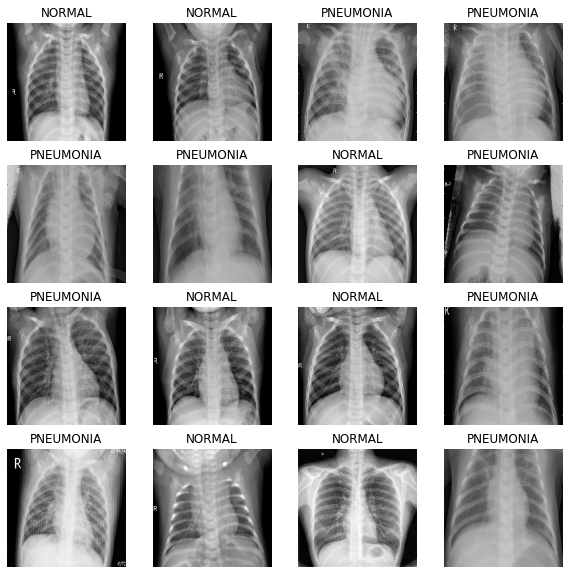

In [45]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 데이터 augmentation 기법

In [46]:
# 이미지를 알맞은 형식으로 바꿉니다.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, (224, 224)) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    label = tf.one_hot(tf.cast(label, tf.int32), depth=2)  # 원-핫 인코딩
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

Image shape:  (224, 224, 3)
Label:  [0. 1.]
624


In [47]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(
        augment,       # augment 함수 적용
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

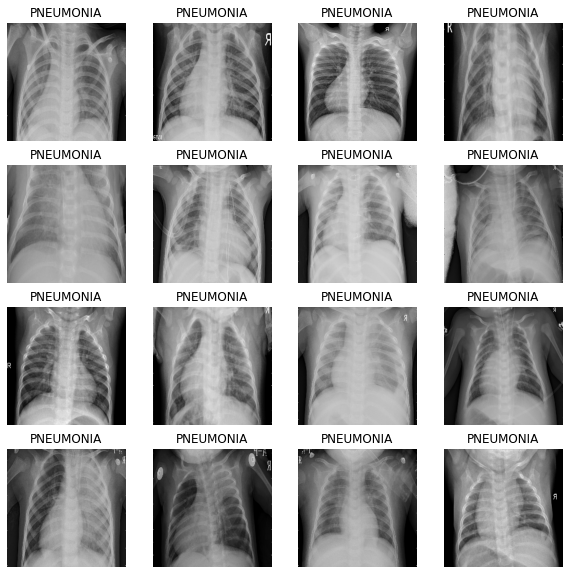

In [48]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n].any():
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 의료영상을 처리하는 CNN 기반 베이스 모델 구현

- 먼저, Convolution block을 만듭니다. 
- conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 
- 그리고 Max Pooling을 합니다.

#### imbalance 처리

In [94]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0  # 1.5로 나누어 가중치 증가

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [95]:
def apply_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, use_augmentation=False):
    if use_augmentation:
        ds = ds.map(
            apply_augmentation,       # augmentation 함수 적용
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds, use_augmentation=False)
train_ds_augmented = prepare_for_training(train_ds.unbatch(), use_augmentation=True)
val_ds = prepare_for_training(val_ds, use_augmentation=False)


### 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교

In [96]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [97]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [98]:
with tf.device('/GPU:0'):
    base_model = build_model()
    aug_model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    base_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    aug_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    base_history = base_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

    aug_history = aug_model.fit(
        train_ds_augmented,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/10
261/261 [==============================] - 66s 196ms/step - loss: 0.3958 - accuracy: 0.8147 - precision: 0.9509 - recall: 0.7917 - val_loss: 0.7532 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 204ms/step - loss: 0.2317 - accuracy: 0.9091 - precision: 0.9723 - recall: 0.9037 - val_loss: 1.5087 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 48s 183ms/step - loss: 0.1800 - accuracy: 0.9388 - precision: 0.9801 - recall: 0.9368 - val_loss: 0.3438 - val_accuracy: 0.8308 - val_precision: 0.8145 - val_recall: 0.9974
Epoch 4/10
261/261 [==============================] - 46s 178ms/step - loss: 0.1838 - accuracy: 0.9328 - precision: 0.9757 - recall: 0.9329 - val_loss: 0.1919 - val_accuracy: 0.9365 - val_precision: 0.9986 - val_recall: 0.9151
Epoch 5/10
261/261 [==============================] - 46s 175ms/step - loss: 0.1607 - accura

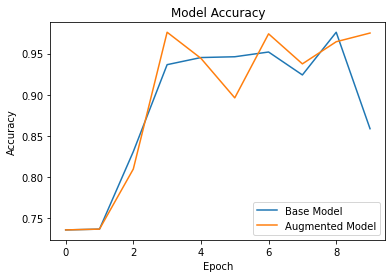

In [99]:
plt.plot(base_history.history['val_accuracy'], label='Base Model')
plt.plot(aug_history.history['val_accuracy'], label='Augmented Model')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

- 초기 에포크(Epoch)에서는 데이터 증강 모델(Augmented Model)이 베이스 모델(Base Model)보다 약간 더 빠른 속도로 정확도가 향상되는 것을 볼 수 있습니다.

- 베이스 모델은 특정 에포크 이후에 정확도가 감소하는 경향을 보이는 반면, 데이터 증강 모델은 비교적 안정적인 성능을 유지합니다.

## Step 4. ResNet-18 구현

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, (224, 224)) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    label = tf.one_hot(tf.cast(label, tf.int32), depth=2)  # 원-핫 인코딩
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [1. 0.]


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [16]:
def residual_block(filters, stride=1):
    def f(x):
        shortcut = x

        # Weight Layer 1
        x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

        # Weight Layer 2
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # Downsampling을 위한 shortcut 조정
        if stride != 1:
            shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        # Identity Connection 및 ReLU 활성화
        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.layers.ReLU()(x)

        return x
    return f

In [17]:
def build_model(input_shape=(224, 224, 3), num_classes=2): # 필요에 따라 조정
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    # conv1
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # conv2_x 
    x = residual_block(64)(x)
    x = residual_block(64)(x)

    # conv3_x 
    x = residual_block(128, stride=2)(x) 
    x = residual_block(128)(x)

    # conv4_x 
    x = residual_block(256, stride=2)(x) 
    x = residual_block(256)(x)

    # conv5_x 
    x = residual_block(512, stride=2)(x) 
    x = residual_block(512)(x)

    # Average Pooling
    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = tf.keras.layers.Flatten()(x)

    # Fully Connected Layer
    x = tf.keras.layers.Dense(1000, activation='relu')(x)  
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

## Step 5. 데이터 imbalance 처리

- 아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅.
- 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정.
- PNEUMONIA 클래스의 가중치를 더 높게 설정

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 1.5  # 1.5로 나누어 가중치 증가

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.90


## Step 6. 모델 훈련

In [19]:
BATCH_SIZE = 32
EPOCHS = 20

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=METRICS
    )

- 모델을 fit 하기 위해 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.

### ResNet-18 모델을 구현하고 학습

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/20
130/130 [==============================] - 61s 245ms/step - loss: 0.6026 - accuracy: 0.8269 - precision: 0.8269 - recall: 0.8269 - val_loss: 5.4944 - val_accuracy: 0.7168 - val_precision: 0.7168 - val_recall: 0.7168
Epoch 2/20
130/130 [==============================] - 31s 237ms/step - loss: 0.3069 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - val_loss: 1.4803 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 0.7207
Epoch 3/20
130/130 [==============================] - 32s 246ms/step - loss: 0.2408 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - val_loss: 0.6318 - val_accuracy: 0.7988 - val_precision: 0.7988 - val_recall: 0.7988
Epoch 4/20
130/130 [==============================] - 32s 248ms/step - loss: 0.2198 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - val_loss: 0.4984 - val_accuracy: 0.8398 - val_precision: 0.8398 - val_recall: 0.8398
Epoch 5/20
130/130 [==============================] - 34s 259ms/step - loss: 0.2061 - accura

## Step 7. 결과 확인과 시각화

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화한다.

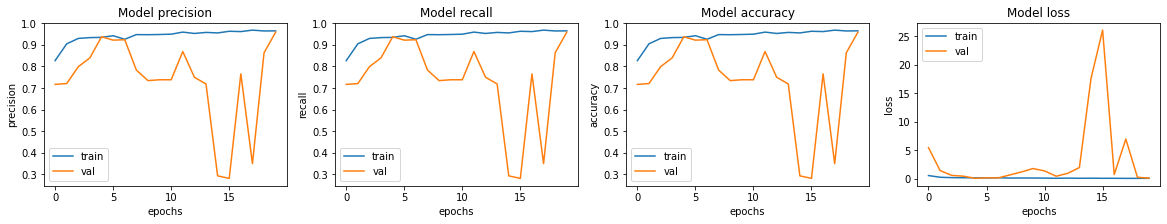

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터로 모델 평가를 해본다.
- 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.7785 - accuracy: 0.8077 - precision: 0.8077 - recall: 0.8077
Loss: 0.7785216569900513,
Accuracy: 0.807692289352417,
Precision: 0.807692289352417,
Recall: 0.807692289352417


## 회고

잔 실수들이 많았던 프로젝트였던거 같다. 코드 분석을 더 해봐야할거 같다.